<font size="6">Prospective Study of Blood Biomarkers for Diabetes Prediction</font>

In [1]:
# Automatically reload modules before execution to reflect changes.
%load_ext autoreload
%autoreload 2

# Data Loading and Setup

## Import Libraries

In [28]:
# Data manipulation
import os
import numpy as np
import pandas as pd

# Statistical analysis
from scipy import stats
import statsmodels.api as sm

# Regex for pattern matching
import re

# Tracking and debugging
import logging

# Visualization
import matplotlib.pyplot as plt
plt.set_loglevel('WARNING')
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

# Import necessary libraries for ML pipeline development
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Import necessary libraries for ML model evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve
)

# Import necessary libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Import non-linear estimator for alternative imputation
from sklearn.ensemble import RandomForestRegressor

# Add src to the system path to access utility functions
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

# Import custom functions
from src.utils import setup_logging
from src.data_utils import load_data, iterative_imputation
from src.analysis_utils import clean_data, calculate_propensity_scores, match_propensity_scores
from src.analysis_utils import run_logistic_regression_on_biomarkers, adjust_p_values, plot_volcano

## Configuration

In [5]:
# Set up logging
setup_logging("INFO")

# Set up random seed
my_random_seed = 19770525 # cuz of "A New Hope"!!
np.random.seed(my_random_seed)

# Define file path and columns
raw_data_path = '../data/raw/test_project_data.csv'
categorical_columns = [
    'subject_id', 
    'sex',
    'prevalent_diabetes', 
    'incident_diabetes'
]
numeric_columns = [
    'age', 
    'BMI', 
    'diabetes_followup_time'
]
biomarker_pattern = '^mtb_'

main_dir = str(Path().resolve().parent)

## Load Dataset

In [6]:
# Load data with `pyarrow` (4x faster)
raw_df = load_data(
    raw_data_path = raw_data_path, 
    categorical_columns = categorical_columns, 
    numeric_columns = numeric_columns, 
    biomarker_pattern = biomarker_pattern
)

# Display the first few rows of the dataset
logging.info("Dataset preview:")
raw_df.head()

2024-09-22 00:19:54,204 - INFO - Dataset shape: (8291, 10007)
2024-09-22 00:19:54,206 - INFO - Dataset preview:


,subject_id,mtb_0018261,mtb_0018266,mtb_0018325,mtb_0018326,mtb_0018327,mtb_0018351,mtb_0018362,mtb_0018470,mtb_0018509,...,mtb_2127305,mtb_2129124,mtb_2129210,mtb_2129554,BMI,age,sex,prevalent_diabetes,incident_diabetes,diabetes_followup_time
0,sbj_0000,5885.011,15177.95,19653.31,12611.670,9042.063,NaN,60124.56,9552.881,NaN,...,NaN,NaN,22112.25,NaN,18.664268,33.81,male,0.0,0.0,14.77
1,sbj_0001,7624.425,10901.94,12129.36,9336.460,21680.930,NaN,83700.80,15068.120,NaN,...,NaN,NaN,NaN,NaN,28.175977,68.56,male,0.0,0.0,14.77
2,sbj_0002,7220.400,18086.69,23707.55,7344.697,26314.650,NaN,82482.38,13911.300,NaN,...,15185.790,NaN,19425.35,NaN,22.971959,55.68,male,0.0,0.0,14.77
3,sbj_0003,6797.486,12364.85,17775.76,25836.150,30563.140,NaN,92839.12,11690.130,NaN,...,NaN,NaN,NaN,NaN,21.960370,43.89,female,0.0,0.0,14.78
4,sbj_0004,NaN,19046.33,18701.06,14137.270,27020.920,NaN,85453.69,9579.896,NaN,...,5318.547,NaN,NaN,NaN,40.454949,47.76,male,0.0,0.0,14.86


# Data Preprocessing

## Data Overview

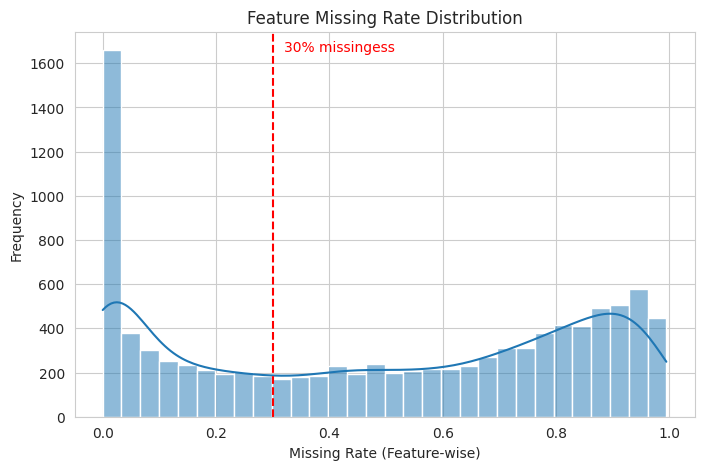

In [7]:
# Feature Missing Rate Distribution
feature_missing_rate_arr = raw_df.isna().mean(axis=0)
print(feature_missing_rate_arr.describe())

plt.figure(figsize=(8, 5))
sns.histplot(feature_missing_rate_arr, kde=True, bins=30)
plt.axvline(x = .3, color = "red", linestyle = '--')
plt.text(.32, plt.ylim()[1]*0.95, '30% missingess', color='red', fontsize=10, ha='left')
plt.title('Feature Missing Rate Distribution')
plt.xlabel('Missing Rate (Feature-wise)')
plt.ylabel('Frequency')
plt.show()

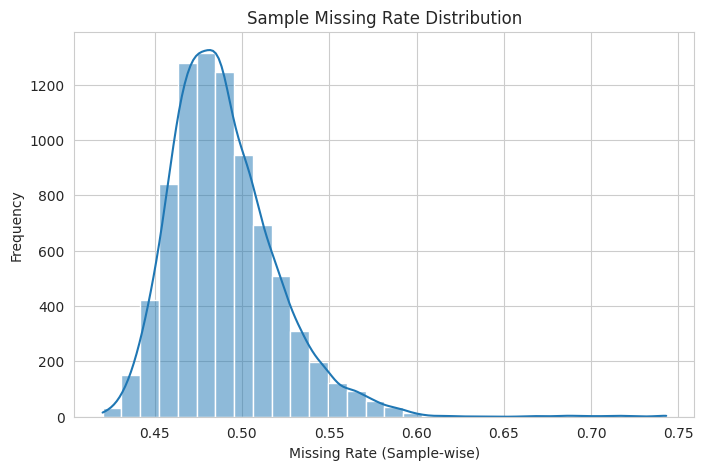

In [8]:
# Sample Missing Rate Distribution
sample_missing_rate_arr = raw_df.isna().mean(axis=1)
print(sample_missing_rate_arr.describe())

plt.figure(figsize=(8, 5))
sns.histplot(sample_missing_rate_arr, kde=True, bins=30)
plt.title('Sample Missing Rate Distribution')
plt.xlabel('Missing Rate (Sample-wise)')
plt.ylabel('Frequency')
plt.show()

### Examine Skewness

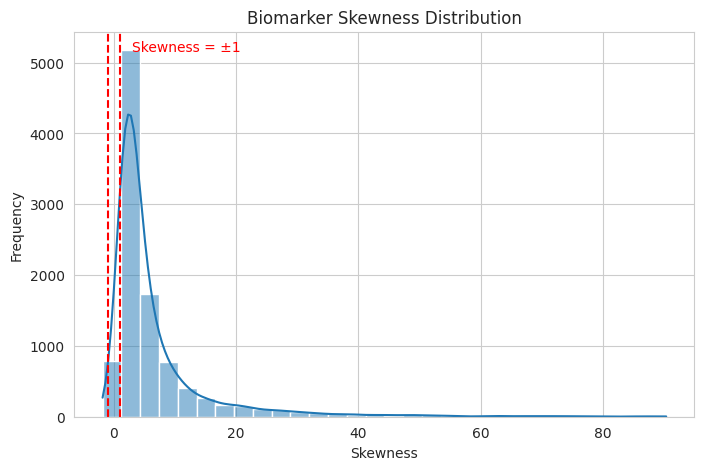

In [9]:
# Biomarker Skewness Distribution
biomarker_cols = [col for col in raw_df.columns if col.startswith('mtb_')]
skewness_raw = raw_df[biomarker_cols].apply(lambda x: stats.skew(x.dropna()))

plt.figure(figsize=(8, 5))
sns.histplot(skewness_raw, kde=True, bins=30)
plt.axvline(x = 1, color = "red", linestyle = '--')
plt.axvline(x = -1, color = "red", linestyle = '--')
plt.text(3, plt.ylim()[1]*0.95, 'Skewness = ±1', color='red', fontsize=10, ha='left')
plt.title('Biomarker Skewness Distribution')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.show()

## Data Transformation

In [10]:
# Encode categorical data
transformed_df = raw_df.copy()
transformed_df['sex'] = transformed_df['sex'].map({'male': 1, 'female': 0})
transformed_df['incident_diabetes'] = transformed_df['incident_diabetes'].map({1.0: 1, 0.0: 0})
transformed_df['prevalent_diabetes'] = transformed_df['prevalent_diabetes'].map({1.0: 1, 0.0: 0})

# Log transform biomarkers
biomarker_cols = [col for col in transformed_df.columns if col.startswith('mtb_')]
transformed_df[biomarker_cols] = transformed_df[biomarker_cols].apply(lambda x: np.log1p(x))

### Confirm Skewness

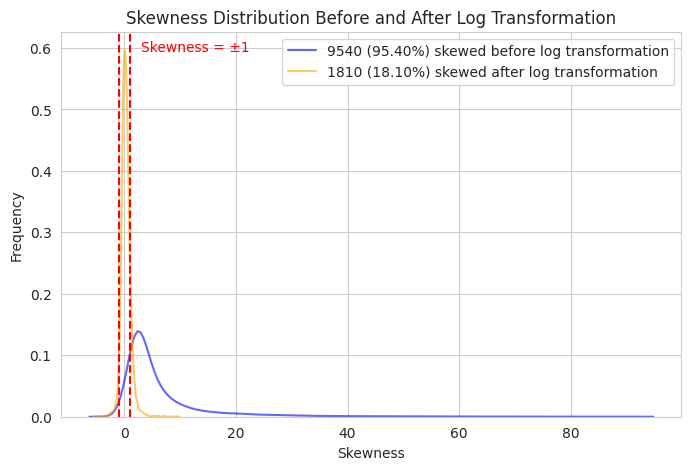

In [11]:
# Calculate skewness after log transformation
skewness_transformed = transformed_df[biomarker_cols].apply(lambda x: stats.skew(x.dropna()))

skewness_raw_counts = len(skewness_raw[abs(skewness_raw) > 1])
skewness_transformed_counts = len(skewness_transformed[abs(skewness_transformed) > 1])

# Calculate percentages
skewness_raw_percentage = (skewness_raw_counts / len(skewness_raw)) * 100
skewness_transformed_percentage = (skewness_transformed_counts / len(skewness_transformed)) * 100

# Plot overlapped skewness before and after log transformation
plt.figure(figsize=(8, 5))

sns.kdeplot(skewness_raw, color='blue', label=f'{skewness_raw_counts} ({skewness_raw_percentage:.2f}%) skewed before log transformation', alpha=0.6)
sns.kdeplot(skewness_transformed, color='orange', label=f'{skewness_transformed_counts} ({skewness_transformed_percentage:.2f}%) skewed after log transformation', alpha=0.6)

plt.axvline(x=1, color="red", linestyle='--')
plt.axvline(x=-1, color="red", linestyle='--')
plt.text(3, plt.ylim()[1] * 0.95, 'Skewness = ±1', color='red', fontsize=10, ha='left')

plt.title('Skewness Distribution Before and After Log Transformation')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.legend()

plt.show()

## Missing Data Imputation

### Multivariate Imputation

In [122]:
X_imputed_df = impute_data(
    imputed_file_path=f"{main_dir}/data/processed/X_imputed_df.pkl",
    transformed_df=transformed_df,
    missing_threshold=0.3,
    exclude_cols=['subject_id',
                  'incident_diabetes',
                  'diabetes_followup_time'
                 ],
    imputer_kwargs={'max_iter': 3,
                    'n_nearest_features': 50,
                    'random_state': my_random_seed,
                    'verbose': 2
                   },
    integer_cols=['sex',
                  'prevalent_diabetes'
                 ]
)

2024-09-22 09:48:00,090 - INFO - /mnt/stsi/stsi1/sfchen/240917_sapientbio_diabetes_biomarker_project/data/processed/X_imputed_df.pkl: File exists. Loading imputed data...


### (Optional) Random Forest-Based Multivariate Imputation

In [123]:
rf_X_imputed_df = impute_data(
    imputed_file_path=f"{main_dir}/data/processed/rf_X_imputed_df.pkl",
    transformed_df=transformed_df,
    missing_threshold=0.3,
    exclude_cols=['subject_id',
                  'incident_diabetes',
                  'diabetes_followup_time'
                 ],
    imputer_kwargs={'max_iter': 3,
                    'n_nearest_features': 50,
                    'random_state': my_random_seed,
                    'verbose': 2
                   },
    integer_cols=['sex', 'prevalent_diabetes'],
    estimator=RandomForestRegressor(
        n_estimators=50,
        random_state=my_random_seed,
        n_jobs=-1
    )
)

2024-09-22 09:48:01,100 - INFO - /mnt/stsi/stsi1/sfchen/240917_sapientbio_diabetes_biomarker_project/data/processed/rf_X_imputed_df.pkl: File exists. Loading imputed data...


# Exploratory Data Analysis (EDA)

## Demographic and Physical Distributions

count    8291.000000
mean       48.042692
std        13.149461
min        24.100000
25%        37.260000
50%        48.530000
75%        58.345000
max        74.240000
Name: age, dtype: float64


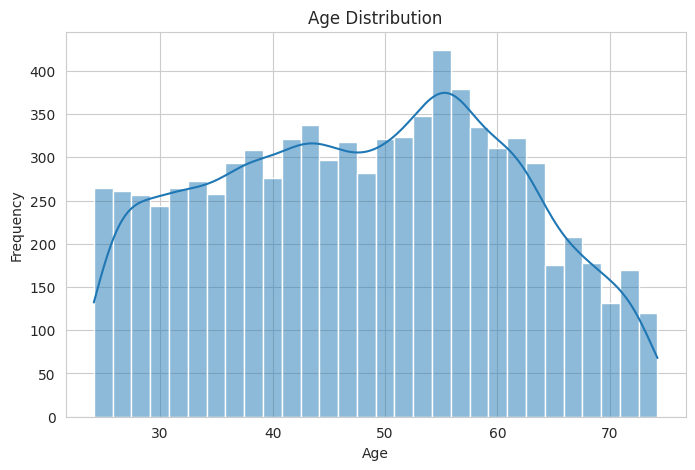

In [99]:
# Age Distribution
print(X_imputed_df['age'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(X_imputed_df['age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

sex
0.0    4410
1.0    3881
Name: count, dtype: int64


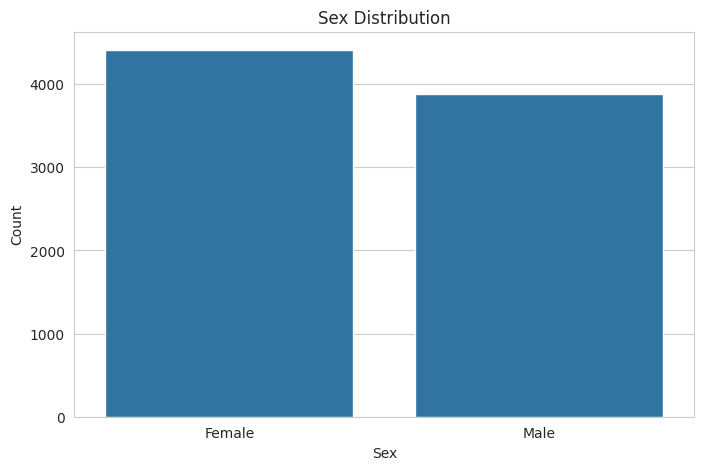

In [100]:
# Sex Distribution
print(X_imputed_df['sex'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='sex', data=X_imputed_df)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

count    8291.000000
mean       26.919999
std         4.671763
min        15.836757
25%        23.636155
50%        26.324310
75%        29.431875
max        55.979629
Name: BMI, dtype: float64


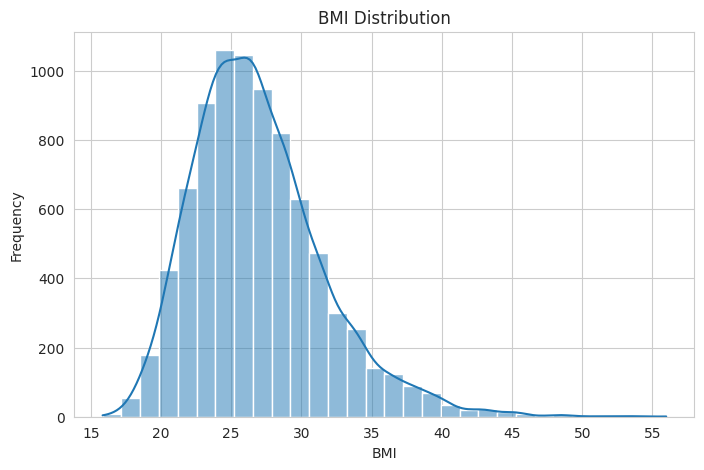

In [101]:
# BMI Distribution
print(X_imputed_df['BMI'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(X_imputed_df['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

## Diabetes Distributions

prevalent_diabetes
0    7840
1     451
Name: count, dtype: int64


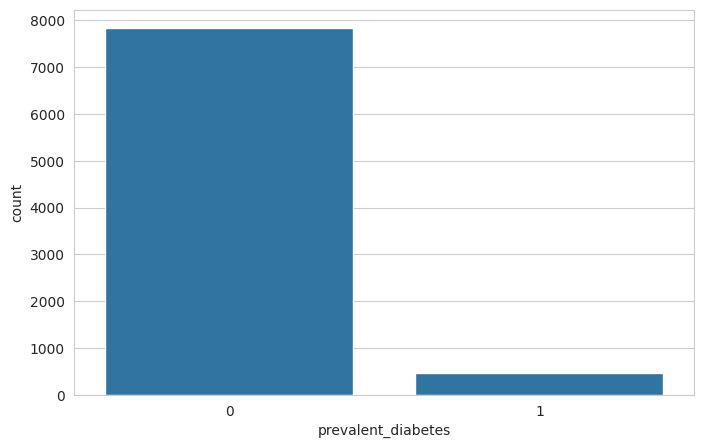

In [102]:
# Prevalent Diabetes Distribution
X_imputed_df['prevalent_diabetes'] = X_imputed_df['prevalent_diabetes'].astype(int)
print(X_imputed_df['prevalent_diabetes'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='prevalent_diabetes', data=X_imputed_df)
# plt.title('Prevalent Diabetes Distribution')
# plt.xlabel('Prevalent Diabetes')
# plt.ylabel('Count')
# plt.xticks([0, 1], ['Control', 'Case'])
plt.show()

incident_diabetes
False    7444
True      704
Name: count, dtype: int64


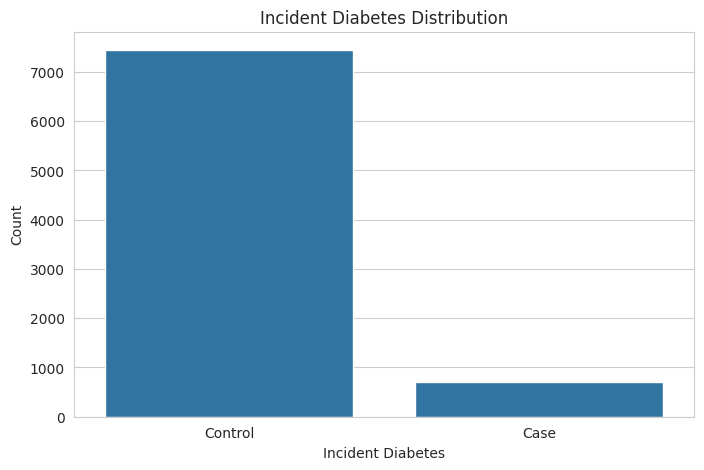

In [103]:
# Incident Diabetes Distribution
print(X_imputed_df['incident_diabetes'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='incident_diabetes', data=X_imputed_df)
plt.title('Incident Diabetes Distribution')
plt.xlabel('Incident Diabetes')
plt.ylabel('Count')
plt.xticks([False, True], ['Control', 'Case'])
plt.show()

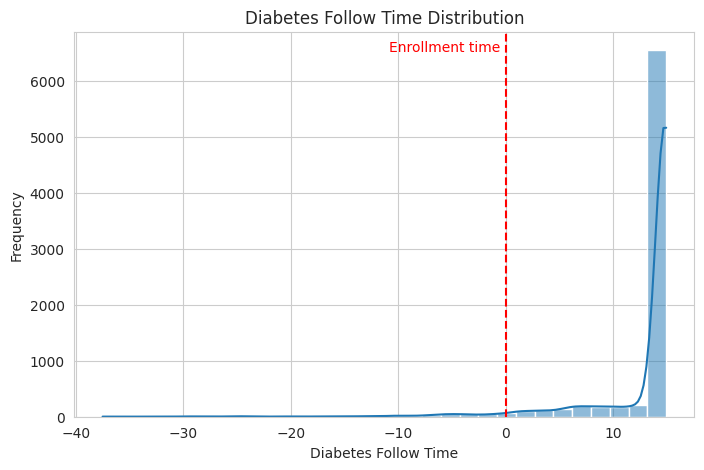

In [104]:
# Diabetes Follow Time Distribution
X_imputed_df['diabetes_followup_time'].describe()

plt.figure(figsize=(8, 5))
sns.histplot(X_imputed_df['diabetes_followup_time'], kde=True, bins=30)
plt.axvline(x = 0, color = "red", linestyle = '--')
plt.text(-0.5, plt.ylim()[1]*0.95, 'Enrollment time', color='red', fontsize=10, ha='right')
plt.title('Diabetes Follow Time Distribution')
plt.xlabel('Diabetes Follow Time')
plt.ylabel('Frequency')
plt.show()

## Label Consistency Checks

In [105]:
# Occruences of prevalent and incident diabetes
X_imputed_df.value_counts(['prevalent_diabetes', 'incident_diabetes'])

prevalent_diabetes  incident_diabetes
0                   False                6993
                    True                  704
1                   False                 451
Name: count, dtype: int64

In [106]:
# Check 1: A subject should not have both prevalent and incident diabetes at the same time
assert X_imputed_df.loc[(X_imputed_df['incident_diabetes'] != 0) & (X_imputed_df['prevalent_diabetes'] != 0), ].empty, \
    "Check failed: There are subjects who have both prevalent and incident diabetes. A subject shouldn't have both at the same time."

# Check 2: If a subject has non-positive follow-up time, they should have prevalent diabetes
assert X_imputed_df.loc[(X_imputed_df['diabetes_followup_time'] <= 0) & (X_imputed_df['prevalent_diabetes'] != 1), ].empty, \
    "Check failed: There are subjects with negative follow-up time who do not have prevalent diabetes."

# Check 3: If a subject has non-positive follow-up time, they should not have incident diabetes
assert X_imputed_df.loc[(X_imputed_df['diabetes_followup_time'] <= 0) & (X_imputed_df['incident_diabetes'] != 0), ].empty, \
    "Check failed: There are subjects with negative follow-up time who have incident diabetes."

# Identifying Blood Biomarkers Associated with Incident Diabetes

## Data Preprocessing and Propensity Score Matching

In [113]:
# Data Preprocessing
cleaned_df = rf_X_imputed_df.copy()
cleaned_df['incident_diabetes'] = cleaned_df['incident_diabetes'].astype(float)
cleaned_df = cleaned_df.dropna(subset=['incident_diabetes']).copy()
cleaned_df = calculate_propensity_scores(cleaned_df, ['age', 'sex', 'BMI'], 'incident_diabetes')

# Feature Engineering
matched_data = match_propensity_scores(cleaned_df, 'incident_diabetes')

## Univariate Logistic Regression for Each Biomarker

In [114]:
# Logistic Regression
biomarker_cols = [col for col in matched_data.columns if col.startswith('mtb_')]
log2_fold_changes, p_values = run_logistic_regression_on_biomarkers(matched_data, ['age', 'sex', 'BMI'], 'incident_diabetes', biomarker_cols)

## Multiple Testing Correction and Identification of Significant Biomarkers

In [115]:
# Adjust p-values for multiple testing using Benjamini-Hochberg correction
corrected_p_values = adjust_p_values(p_values)

# Identify significant biomarkers based on corrected p-values and fold changes
pval_threshold = -np.log10(0.05)  # p-value < 0.05
fc_threshold = 1  # Log2 fold change threshold
significant_biomarkers = pd.DataFrame({
    'biomarker': biomarker_cols,
    'log2FC': log2_fold_changes,
    'corrected_p_value': corrected_p_values
}).query(f'abs(log2FC) > {fc_threshold} and corrected_p_value < 0.05')

display(significant_biomarkers)

,biomarker,log2FC,corrected_p_value
195,mtb_0089622,1.025768,0.032564
261,mtb_0122491,1.688254,0.048779
267,mtb_0127332,1.755349,0.018970
716,mtb_0444500,1.097538,0.034004
1155,mtb_0733731,1.100669,0.000011
1349,mtb_0841776,1.209411,0.030271
1435,mtb_0880988,1.007098,0.005496
1528,mtb_0929701,1.016858,0.010959
1787,mtb_1068685,-1.018993,0.001625
2486,mtb_1465252,-1.460685,0.000857


## Volcano Plot of Significant Biomarkers

In [116]:
significant_biomarkers.shape

(14, 3)

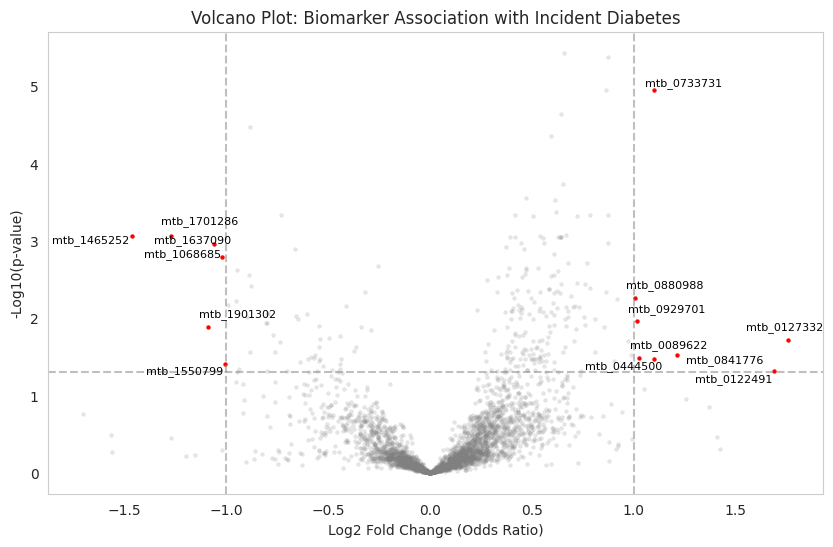

In [117]:
# Volcano plot to visualize significant biomarkers and their associations (new rf)
plot_volcano(biomarker_cols, log2_fold_changes, corrected_p_values)

In [111]:
significant_biomarkers.shape

(9, 3)

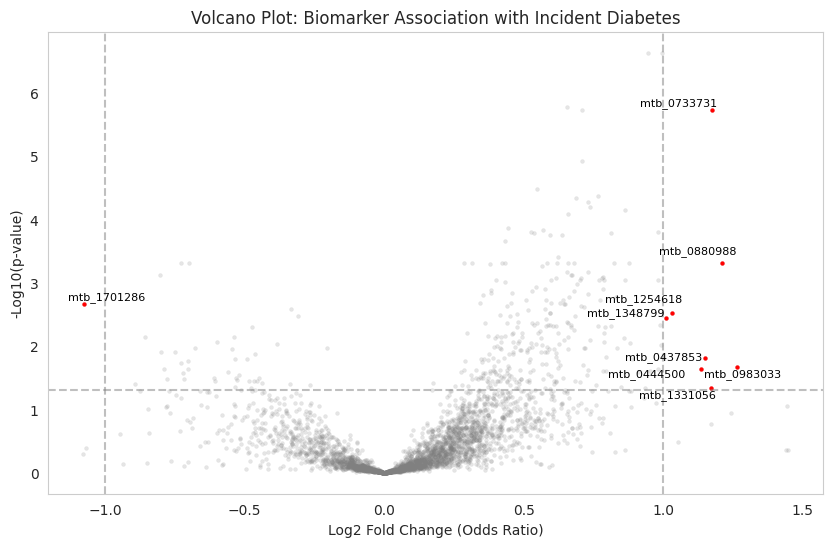

In [112]:
# Volcano plot to visualize significant biomarkers and their associations (new default)
plot_volcano(biomarker_cols, log2_fold_changes, corrected_p_values)

In [91]:
significant_biomarkers.shape

(20, 3)

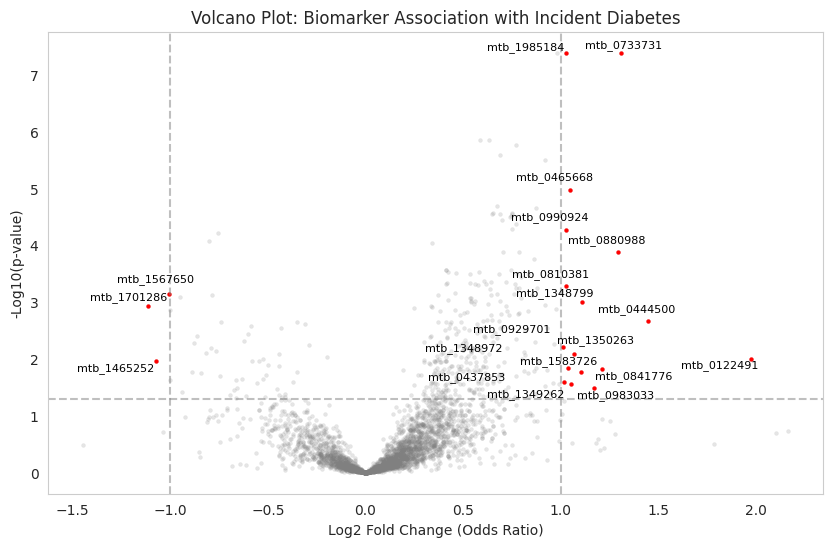

In [90]:
# Volcano plot to visualize significant biomarkers and their associations (old default)
plot_volcano(biomarker_cols, log2_fold_changes, corrected_p_values)

In [95]:
significant_biomarkers.shape

(14, 3)

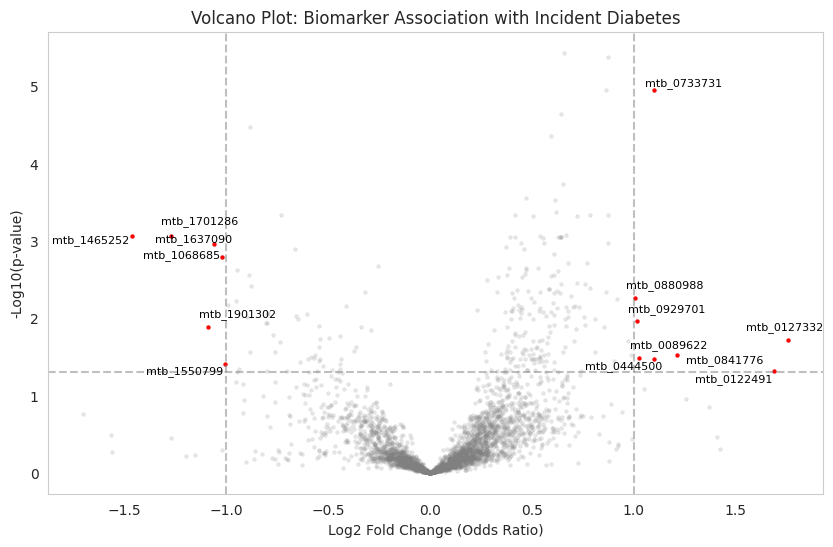

In [96]:
# Volcano plot to visualize significant biomarkers and their associations (old rf)
plot_volcano(biomarker_cols, log2_fold_changes, corrected_p_values)

# Machine Learning Models

## Classifier

In [ ]:
target_df = X_imputed_df.loc[
        ~(X_imputed_df['incident_diabetes'].isna()) &
        (X_imputed_df['prevalent_diabetes'] == 0) &
        (X_imputed_df['diabetes_followup_time'] > 0),
].copy()

In [27]:
# Prepare the data (already done earlier)
X = target_df.drop(columns=['subject_id', 'incident_diabetes'])  # Features
y = target_df['incident_diabetes']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=my_random_seed),
    'Imbalanced Random Forest': BalancedRandomForestClassifier(n_estimators=100, random_state=my_random_seed, sampling_strategy = 'all', replacement = True, bootstrap = False),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=my_random_seed),
    'LightGBM': LGBMClassifier(random_state=my_random_seed, verbose=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=my_random_seed)
}

# # Function to train and evaluate models
# def evaluate_models(models, X_train, y_train, X_test, y_test):
#     plt.figure(figsize=(10, 8))
#     for model_name, model in models.items():
#         # Create pipeline with scaling and model
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),  # Standardize features
#             (model_name, model)  # The actual model
#         ])
        
#         # Train the model
#         pipeline.fit(X_train, y_train)
        
#         # Predict probabilities
#         y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        
#         # Calculate AUC
#         auc = roc_auc_score(y_test, y_pred_prob)
#         print(f"{model_name} AUC: {auc:.2f}")
        
#         # Plot ROC curve
#         fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
#         plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    
#     # Plot random baseline
#     plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve Comparison of Models')
#     plt.legend(loc='lower right')
#     plt.grid()
#     plt.show()

# # Evaluate all models
# evaluate_models(models, X_train, y_train, X_test, y_test)



Logistic Regression AUC: 0.89
SVM AUC: 0.92
Random Forest AUC: 0.93
Imbalanced Random Forest AUC: 0.91
CatBoost AUC: 0.99
LightGBM AUC: 0.99
XGBoost AUC: 0.99


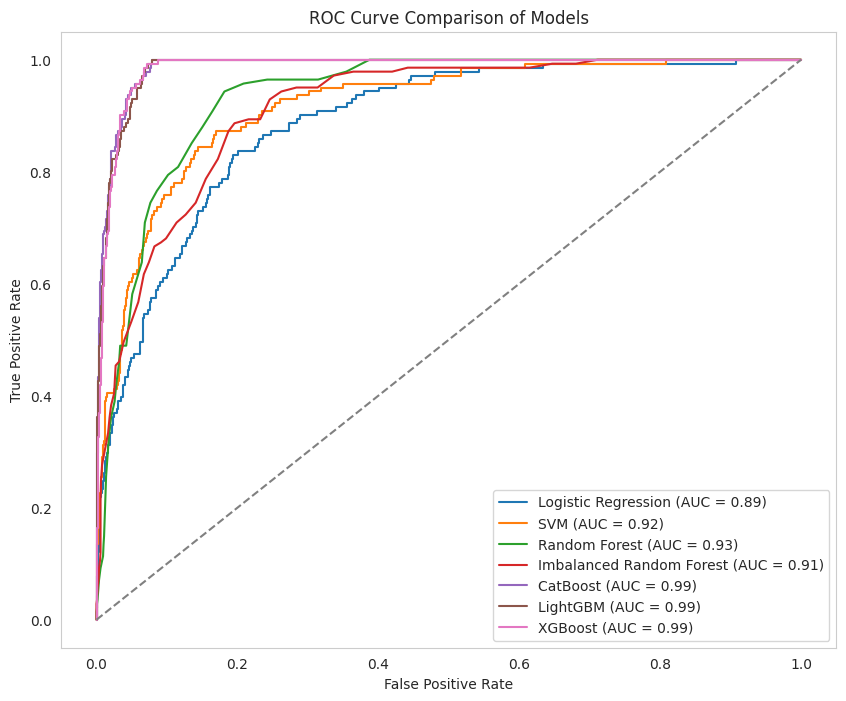

In [29]:
# Initialize dictionaries to store models, predictions, and prediction probabilities
trained_models = {}
predictions = {}
prediction_probs = {}

# Function to train models, save them in a dictionary, and plot ROC comparison
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for model_name, model in models.items():
        # Create pipeline with scaling and model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardize features
            (model_name, model)  # The actual model
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Save the trained model in the dictionary
        trained_models[model_name] = pipeline
        
        # Make predictions and save them
        y_pred = pipeline.predict(X_test)
        predictions[model_name] = y_pred
        
        # Save the predicted probabilities
        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        prediction_probs[model_name] = y_pred_prob
        
        # Calculate AUC
        auc = roc_auc_score(y_test, y_pred_prob)
        print(f"{model_name} AUC: {auc:.2f}")
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    
    # Plot random baseline
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison of Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return trained_models, predictions, prediction_probs

# Call the function to train models and generate the ROC curve comparison
trained_models, predictions, prediction_probs = train_and_evaluate_models(models, X_train, y_train, X_test, y_test)


In [30]:
target_df = X_imputed_df.loc[~(X_imputed_df['incident_diabetes'].isna()) & (X_imputed_df['prevalent_diabetes'] == 0) & (X_imputed_df['diabetes_followup_time'] > 0), ].copy()
target_df = target_df[['subject_id'] + ['age', 'sex', 'BMI', 'incident_diabetes'] + list(significant_biomarkers['biomarker'])]

In [31]:
target_df

,subject_id,age,sex,BMI,incident_diabetes,mtb_0122491,mtb_0437853,mtb_0444500,mtb_0465668,mtb_0733731,...,mtb_0990924,mtb_1348799,mtb_1348972,mtb_1349262,mtb_1350263,mtb_1465252,mtb_1567650,mtb_1583726,mtb_1701286,mtb_1985184
0,sbj_0000,33.81,1,18.664268,0.0,12.075063,10.574955,9.011635,9.703109,11.029660,...,12.278206,12.514249,14.972099,12.035001,15.589921,11.973146,11.627470,12.257754,11.822107,10.051694
1,sbj_0001,68.56,1,28.175977,0.0,12.092842,10.911591,9.036342,10.623070,11.781174,...,12.066055,12.481889,15.021692,11.944977,15.615648,11.717181,11.134635,12.076348,11.571578,10.943668
2,sbj_0002,55.68,1,22.971959,0.0,12.015760,10.512217,9.564467,9.787962,11.554885,...,12.195695,12.224094,14.830985,11.932943,15.378994,11.727652,11.394590,12.218053,11.787828,9.687076
3,sbj_0003,43.89,0,21.960370,0.0,12.196247,10.688592,9.603725,10.624175,11.921262,...,12.480120,12.428312,14.949487,11.992203,15.557726,11.771327,11.455552,12.072221,11.709826,10.279321
4,sbj_0004,47.76,1,40.454949,0.0,12.299302,10.591205,9.242415,10.790924,12.182270,...,12.595167,12.019784,14.518405,11.876909,15.100478,11.671140,11.171983,12.021117,11.451572,10.905661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8286,sbj_8286,42.02,0,22.170880,0.0,11.936183,10.571682,9.044332,9.692102,11.073207,...,11.809384,12.639984,14.905172,11.912183,15.521558,11.956442,11.411815,12.355730,11.927216,9.389531
8287,sbj_8287,41.54,1,33.632810,0.0,12.161272,10.566719,9.212132,10.153582,12.527624,...,12.782039,13.010941,15.206713,12.124002,15.933973,11.823502,10.980772,12.332918,12.175742,10.297619
8288,sbj_8288,58.15,0,25.497120,0.0,11.924313,10.691554,9.290881,10.429311,11.995353,...,11.305986,12.250499,14.571774,11.650369,15.249410,11.424223,11.523482,12.481702,11.687737,10.020247
8289,sbj_8289,45.84,1,24.075310,0.0,12.044513,9.958994,9.023635,9.432853,10.886306,...,12.113078,12.485536,14.775877,11.898540,15.460433,12.107010,12.091991,12.352842,12.071569,9.154276


In [32]:
import pandas as pd
import numpy as np

def filter_highly_correlated_features(df, threshold=0.7):
    """
    Filters out features with high collinearity, keeping only one among the correlated pairs.
    
    :param df: Pandas DataFrame with features as columns.
    :param threshold: Correlation threshold above which features are considered highly correlated.
    :return: DataFrame with highly correlated features removed.
    """
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)

    # Mask the upper triangle and filter correlations above the threshold
    high_corr_pairs = corr_matrix.where(mask).stack().reset_index()
    high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

    high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > threshold]
    # Keep track of features to drop
    features_to_drop = set()

    # Iterate over high correlation pairs and drop one of the features
    for _, row in high_corr_pairs.iterrows():
        feature_1, feature_2 = row['Feature_1'], row['Feature_2']
        if feature_1 not in features_to_drop and feature_2 not in features_to_drop:
            # Drop one of the two features (you could customize this logic)
            features_to_drop.add(feature_2)  # Add feature_2 to drop list (arbitrary choice)
            print(feature_1, feature_2)

    # Return the DataFrame with highly correlated features removed
    return df.drop(columns=list(features_to_drop)), list(features_to_drop)

# Example usage:
# filtered_df, dropped_features = filter_highly_correlated_features(test_scaled_X_df)
# print("Dropped features due to high collinearity:", dropped_features)
# print(filtered_df.head())


/tmp/ipykernel_229307/2405636215.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(pairwise_distances, method='ward')  # Ward's method for clustering


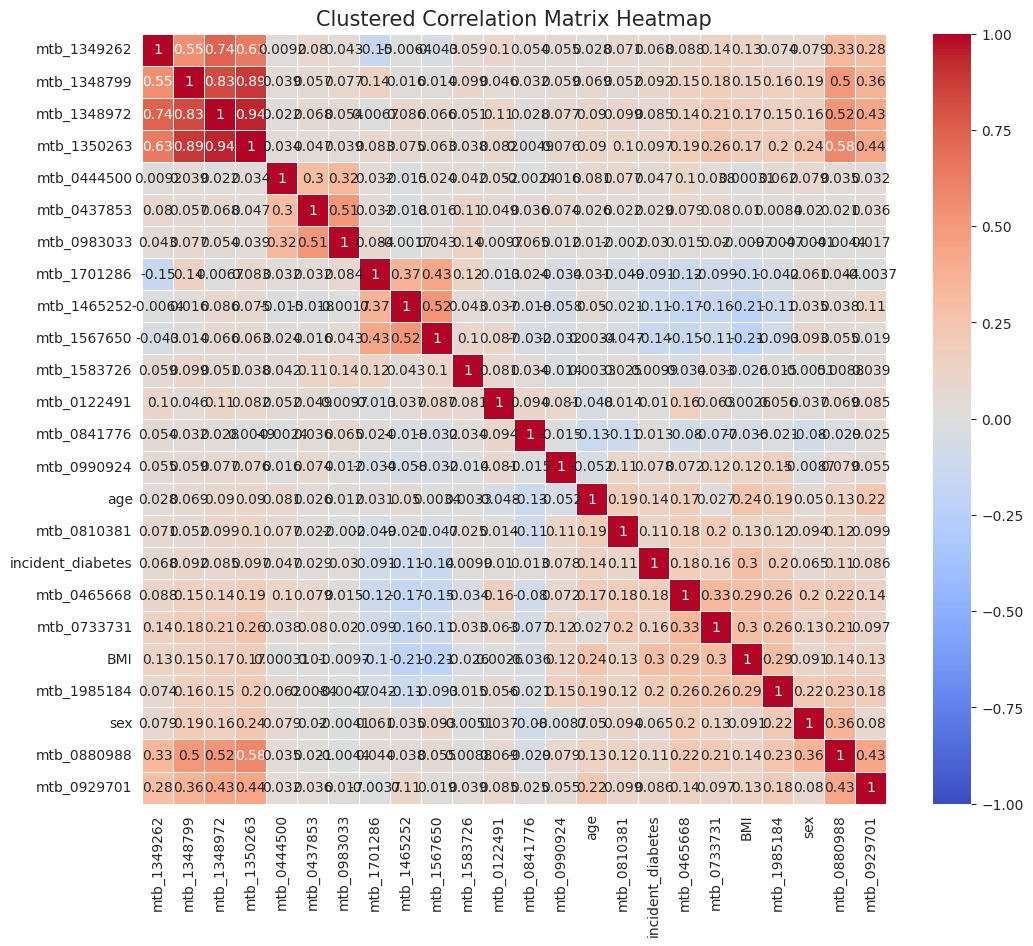

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Assuming df is your DataFrame
# Compute the correlation matrix
correlation_matrix = target_df[[i for i in target_df.columns if i != 'subject_id']].corr()

correlation_matrix.fillna(0, inplace=True)

# Perform hierarchical clustering
pairwise_distances = 1 - correlation_matrix.abs()  # Use absolute correlations for clustering
linkage_matrix = linkage(pairwise_distances, method='ward')  # Ward's method for clustering

# Reorder the correlation matrix based on clustering
col_order = leaves_list(linkage_matrix)
clustered_correlation_matrix = correlation_matrix.iloc[col_order, col_order]

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a heatmap with the reordered correlation matrix
sns.heatmap(clustered_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Set title
plt.title('Clustered Correlation Matrix Heatmap', size=15)

# Display the plot
plt.show()


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fastcluster  # Import fastcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import leaves_list

# Assuming df is your DataFrame
# Compute the correlation matrix
correlation_matrix = target_df[[i for i in target_df.columns if i != 'subject_id']].corr()
correlation_matrix.fillna(0, inplace=True)

# Convert the correlation matrix to a distance matrix
# Use `1 - correlation` to create a distance metric
pairwise_distances = 1 - correlation_matrix.abs()

# Convert the distance matrix into condensed form
# Fastcluster expects a condensed distance matrix for efficient clustering
condensed_distances = pdist(pairwise_distances)

# Perform fast hierarchical clustering using fastcluster's linkage_vector
# Specify Ward's method and desired metric
linkage_matrix = fastcluster.linkage_vector(condensed_distances, method='ward')

# Reorder the correlation matrix based on clustering
col_order = leaves_list(linkage_matrix)
clustered_correlation_matrix = correlation_matrix.iloc[col_order, col_order]

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a heatmap with the reordered correlation matrix
sns.heatmap(clustered_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Set title
plt.title('Clustered Correlation Matrix Heatmap using Fastcluster', size=15)

# Display the plot
plt.show()


AssertionError: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fastcluster  # Import fastcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import leaves_list

# Assuming df is your DataFrame
# Compute the correlation matrix
correlation_matrix = target_df[[i for i in target_df.columns if i != 'subject_id']].corr()
correlation_matrix.fillna(0, inplace=True)

# # Convert the correlation matrix to a distance matrix
# # Use `1 - correlation` to create a distance metric
# pairwise_distances = 1 - correlation_matrix.abs()

# # Convert the distance matrix into condensed form
# # Fastcluster expects a condensed distance matrix for efficient clustering
# condensed_distances = pdist(pairwise_distances)

# Perform fast hierarchical clustering using fastcluster's linkage_vector
# Specify Ward's method and desired metric
linkage_matrix = fastcluster.linkage_vector(correlation_matrix, method='ward')

# Reorder the correlation matrix based on clustering
col_order = leaves_list(linkage_matrix)
clustered_correlation_matrix = correlation_matrix.iloc[col_order, col_order]

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a heatmap with the reordered correlation matrix
sns.heatmap(clustered_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)

# Set title
plt.title('Clustered Correlation Matrix Heatmap using Fastcluster', size=15)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Exclude 'subject_id' and 'incident_diabetes'
df_filtered = target_df.drop(columns=['subject_id', 'incident_diabetes'])

# Compute the correlation matrix
correlation_matrix = df_filtered.corr()

# Create a graph object
G = nx.Graph()

# Set correlation threshold for edges (e.g., 0.5)
correlation_threshold = 0.5

# Add nodes
for col in correlation_matrix.columns:
    G.add_node(col)

# Add edges based on the correlation threshold
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= correlation_threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j], weight=corr_value)

# Draw the graph
plt.figure(figsize=(12, 12))

# Position nodes using spring layout for a better structure
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')

# Draw edges with varying width based on the correlation strength
edges = G.edges(data=True)
edge_weights = [G[u][v]['weight'] for u, v, d in edges]
nx.draw_networkx_edges(G, pos, width=[3 * abs(weight) for weight in edge_weights])

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Display the plot
plt.title('Correlation Network Plot')
plt.show()


In [ ]:
corr_matrix = target_df[[i for i in target_df.columns if i != 'subject_id']].corr().abs()

In [ ]:
drop_target_df, drop_list = filter_highly_correlated_features(target_df[[i for i in target_df.columns if i != 'subject_id']])

In [ ]:
drop_list

In [ ]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the data
X = target_df.drop(columns=['subject_id', 'incident_diabetes'] + drop_list)  # Features
y = target_df['incident_diabetes']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=my_random_seed, stratify=y)

# Step 3: Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('logreg', LogisticRegression(solver='liblinear'))  # Logistic regression model
])

# Step 4: Train the model
pipeline.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Step 6: Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 7: Calculate and display AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc:.2f}")

# Step 8: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# Import necessary libraries for models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Import evaluation tools
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data (already done earlier)
X = target_df.drop(columns=['subject_id', 'incident_diabetes'])  # Features
y = target_df['incident_diabetes']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=my_random_seed),
    'Imbalanced Random Forest': BalancedRandomForestClassifier(n_estimators=100, random_state=my_random_seed, sampling_strategy = 'all', replacement = True, bootstrap = False),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=my_random_seed),
    'LightGBM': LGBMClassifier(random_state=my_random_seed, verbose=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=my_random_seed)
}

# Function to train and evaluate models
def evaluate_models(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        # Create pipeline with scaling and model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardize features
            (model_name, model)  # The actual model
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Predict probabilities
        y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate AUC
        auc = roc_auc_score(y_test, y_pred_prob)
        print(f"{model_name} AUC: {auc:.2f}")
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    
    # Plot random baseline
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison of Models')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Evaluate all models
evaluate_models(models, X_train, y_train, X_test, y_test)



## Survival-based

## Meta-learning

In [ ]:
## Data Splitting
## Model Training
## Model Evaluation
### ROC AUC Score
### Classification Report
### Confusion Matrix
## ROC Curve

# Report

## Method

## Results

## Discussion

1. The study cohort has relative higher overall case rate (13.9%) at the end of follow-up period than general Americans in 2021 (11.6%) according to AHA (https://diabetes.org/about-diabetes/statistics/about-diabetes).
2. Imputation could be fine-tuned with more iterations and nearest neighbors while coming with higher computaitonal complexity.


- Interpretation of Significant Biomarkers
- Model Performance
- Limitations

## Conclusion

## References